In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import cv2
import scipy
import progressbar
class DatasetManager():
  def __init__(self,dataset_name):
    self.data=self.load_dataset(dataset_name)

  def load_dataset(self,name):
    if name=='lsp':
      df=dict()
      df['images']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Leeds Sports Dataset NPY.npy')
      df['poses']=self.to_relative_coord(np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Resized Poses.npy'),220)
      #df['scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale.npy')

      df['test images']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Leeds Sports Dataset NPY Test.npy')
      df['test poses']=self.to_relative_coord(np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Resized Poses Test.npy'),220)
      #df['test scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale Test.npy')
      return df

  def compare_pose(self,index,model,test):
    #Compare ground truth vs predicted pose
    if test:
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['test images'][index:index+1]),220)
    else:
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['images'][index:index+1]),220)
    pose_width,pose_height=predicted_pose[0][:14],predicted_pose[0][14:]
    plt.figure(figsize=(10,10))
    if test:
      plt.imshow(self.data['test images'][index])
    else:
      plt.imshow(self.data['images'][index])
    plt.scatter(pose_width,pose_height,c='g',label='Predicted')
    if test:
      plt.scatter(self.to_absolute_coord(dataset.data['test poses'][index][0],220),self.to_absolute_coord(dataset.data['test poses'][index][1],220),c='r',label='True')
    else:
      plt.scatter(self.to_absolute_coord(dataset.data['poses'][index][0],220),self.to_absolute_coord(dataset.data['poses'][index][1],220),c='r',label='True')
    plt.legend()
    plt.show()

  def augment_images(self):
    new_images=[]
    new_poses=[]
    for idx in progressbar.progressbar(range(self.data['poses'].shape[0])):
      x,y=self.data['poses'][idx][0],self.data['poses'][idx][1]
      image=self.data['images'][idx]
      #Flip image at 50%
      if np.random.randint(2)==1:
        image=np.fliplr(image)
        x=-x
      if np.random.randint(2)==1:
        image=np.flipud(image)
        y=-y

      #transform image
      #transformation_scale=np.array([np.random.rand()*2-1,np.random.rand()*2-1,0])*0.4
      #image=scipy.ndimage.shift(image,(transformation_scale*220).astype(int),mode='nearest')
      x+=transformation_scale[0]*2
      y+=transformation_scale[1]*2

      new_images.append(image)
      new_poses.append(np.array([x,y]))

    return np.array(new_images),np.array(new_poses)
  def test_pdj(self,model,joint_index):
    joint_index=['Right elbow','Right wrist']
    name2index={'Right ankle':0,
    'Right knee':1,
    'Right hip':2,
    'Left hip':3,
    'Left knee':4,
    'Left ankle':5,
    'Right wrist':6,
    'Right elbow':7,
    'Right shoulder':8,
    'Left shoulder':9,
    'Left elbow':10,
    'Left wrist':11,
    'Neck':12,
    'Head top':13}
    min_d,max_d=0,1
    pred=model.model.predict(self.data['test images'])
    true=self.data['test poses']

    pred_x,pred_y=pred[:,:14],pred[:,14:]
    true_x,true_y=true[:,0],true[:,1]

    distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)
    arr=[[]for _ in joint_index]
    for x in np.arange(min_d,max_d,0.001):
      for idx,joint in enumerate(joint_index):
        arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
    for idx,joint in enumerate(joint_index):
      plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
    plt.legend()
    plt.show()
  def to_relative_coord(self,coord,size):
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    return (coord+1)/2*size

class DeepPoseModel():
  def __init__(self,dataset,training_config):
    self.dataset=dataset
    self.training_config=training_config

    self.model=self.define_model()
    self.cascade_1=self.define_model(final_op=2)

    self.model.compile(optimizer=tf.keras.optimizers.Adam(training_config['Learning Rate']),loss=tf.keras.losses.mse)
    self.load_model()

    if training_config['Train model'] == True:
      self.train_model()

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)

  def load_model(self):
    checkpoint_dir = '/content/drive/My Drive/logs/DeepPosev1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(model=self.model,cascade=self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self,coord,size):
    #Change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    return (coord+1)/2*size

  def draw_pose(self,image_name):
    #Model draw pose on new image
    img=plt.imread(image_name)

    img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
    poses=self.model.predict(np.array([img_resized]))[0]
    poses_x,poses_y=poses[:14],poses[14:]
    poses_x=self.to_absolute_coord(poses_x,img.shape[1])
    poses_y=self.to_absolute_coord(poses_y,img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x,poses_y,c='r')
    plt.show()

  def train_model(self):

    #Concatenate [ [X_coord], [Y_coord] ] -> [ Xcoord, Y_coord ]
    y_data=np.concatenate((self.dataset.data['poses'][:,0],self.dataset.data['poses'][:,1]),axis=1)
    y_val=np.concatenate((self.dataset.data['test poses'][:,0],self.dataset.data['test poses'][:,1]),axis=1)
    val_dataset = tf.data.Dataset.from_tensor_slices((self.dataset.data['test images'], y_val))
    val_dataset = val_dataset.batch(64)

    loss,val_loss=[],[]
    for epoch in range(self.training_config['Epochs']):
      print('Epoch',epoch+1)
      training_history=self.model.fit(x=self.dataset.data['images'],y=y_data,epochs=1,batch_size=128,validation_data=val_dataset,verbose=2)
      loss.append(training_history.history['loss'])
      val_loss.append(training_history.history['val_loss'])
      #dataset.draw_pose(0,self)
      if (epoch+1)%10==0:
        self.save_model()
    self.training_log={'loss':loss,'val_loss':val_loss}
  def define_model(self,final_op=28):
    #Changes made on model architecture
    #LRN->BN, Pooling->Strided Convolution
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(final_op,activation='linear'))
    return model

In [ ]:
with tf.device('/device:GPU:0'):
  dataset=DatasetManager('lsp')
  DeepPose=DeepPoseModel(dataset,{'Train model':False,'Learning Rate':0.0005,'Epochs':100})

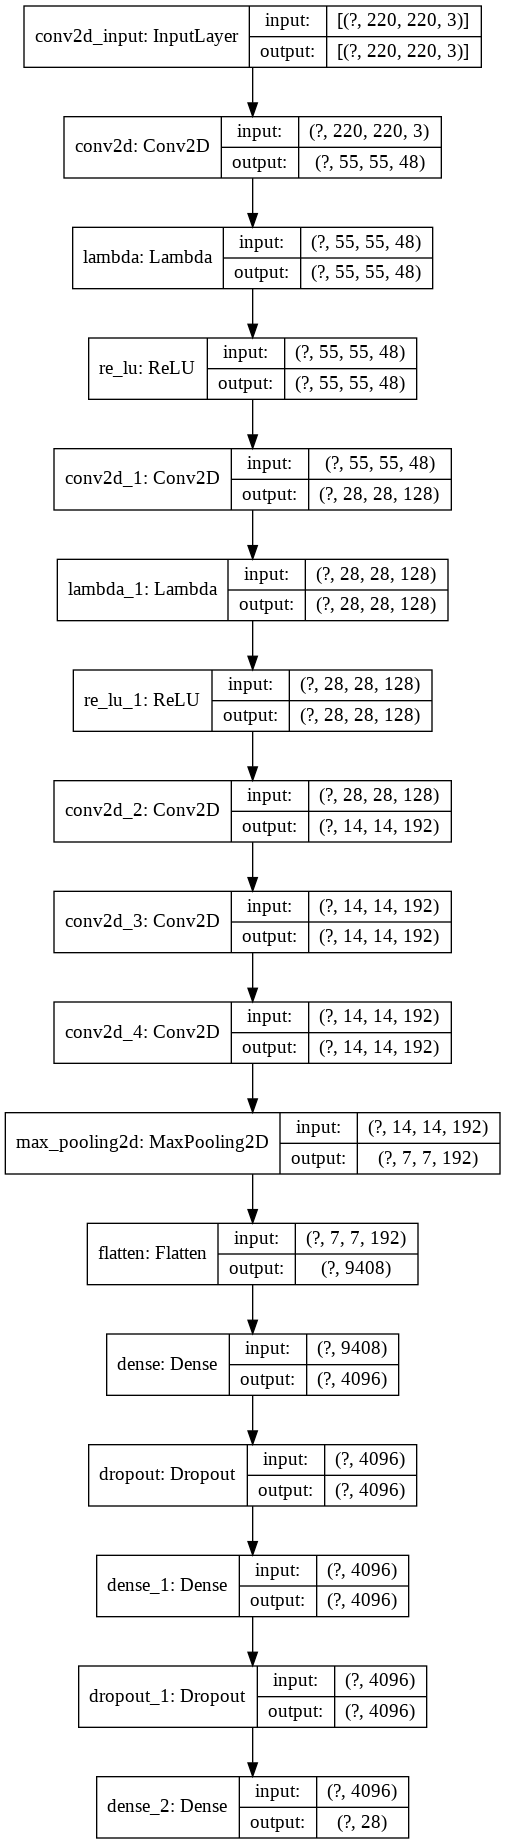

In [ ]:
tf.keras.utils.plot_model(DeepPose.model,show_shapes=True)

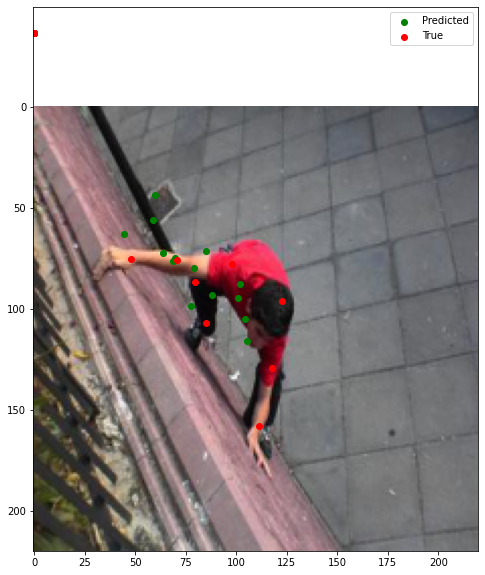

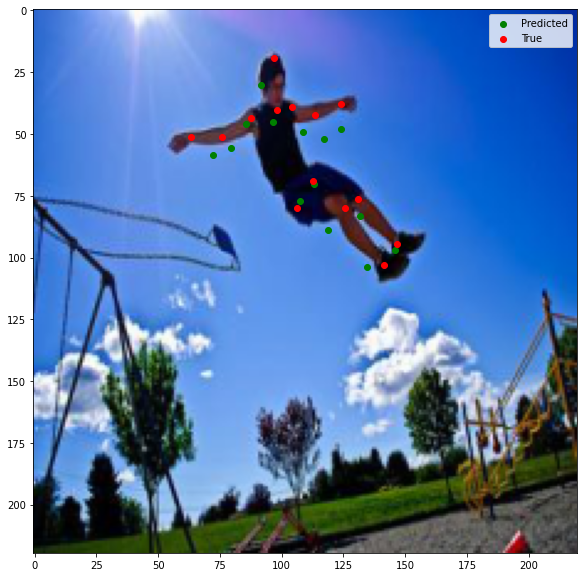

In [ ]:
dataset.compare_pose(10,DeepPose,True)
dataset.compare_pose(100,DeepPose,False)

In [ ]:
DeepPose.draw_pose('286750c0-d9bc-11ea-bbdd-9f2d1f94761b.jpg')


In [ ]:
dataset.test_pdj(DeepPose,['Right wrist','Right elbow'])

In [ ]:
plt.plot(DeepPose.training_log['loss'],label='Training Loss')
plt.plot(DeepPose.training_log['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
image,joints=dataset.augment_images()
joints.shape

In [ ]:
dataset.data['poses'].shape

# PyTorch implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from torch.utils.data import DataLoader, Dataset
import progressbar

class DatasetManager:
    def __init__(self, dataset_name):
        # Initializes the DatasetManager object with the specified dataset.
        self.data = self.load_dataset(dataset_name)

    def load_dataset(self, name):
        # Loads the specified dataset (e.g., 'lsp') and returns a dictionary with data arrays.
        if name == 'lsp':
            df = dict()
            # Load images and poses for training and testing
            df['images'] = np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Leeds Sports Dataset NPY.npy')
            df['poses'] = self.to_relative_coord(np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Resized Poses.npy'), 220)
            
            df['test images'] = np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Leeds Sports Dataset NPY Test.npy')
            df['test poses'] = self.to_relative_coord(np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Resized Poses Test.npy'), 220)
            return df

    def compare_pose(self, index, model, test=False):
        # Compares the ground truth pose with the predicted pose from the model.
        with torch.no_grad():
            if test:
                predicted_pose = self.to_absolute_coord(model(self.data['test images'][index:index+1]), 220)
            else:
                predicted_pose = self.to_absolute_coord(model(self.data['images'][index:index+1]), 220)

        # Split predicted coordinates into x and y components
        pose_width, pose_height = predicted_pose[0][:14], predicted_pose[0][14:]
        plt.figure(figsize=(10, 10))
        
        # Display the corresponding image
        if test:
            plt.imshow(self.data['test images'][index])
        else:
            plt.imshow(self.data['images'][index])
        
        # Plot predicted poses
        plt.scatter(pose_width, pose_height, c='g', label='Predicted')
        
        # Plot ground truth poses
        if test:
            plt.scatter(self.to_absolute_coord(self.data['test poses'][index][0], 220), 
                        self.to_absolute_coord(self.data['test poses'][index][1], 220), c='r', label='True')
        else:
            plt.scatter(self.to_absolute_coord(self.data['poses'][index][0], 220), 
                        self.to_absolute_coord(self.data['poses'][index][1], 220), c='r', label='True')
        
        plt.legend()
        plt.show()

    def augment_images(self):
        # Augments images by randomly flipping and transforming them, and adjusts the corresponding poses.
        new_images = []
        new_poses = []
        for idx in progressbar.progressbar(range(self.data['poses'].shape[0])):
            x, y = self.data['poses'][idx][0], self.data['poses'][idx][1]
            image = self.data['images'][idx]
            
            # Randomly flip images horizontally and adjust x-coordinates of poses
            if np.random.randint(2) == 1:
                image = np.fliplr(image)
                x = -x
            
            # Randomly flip images vertically and adjust y-coordinates of poses
            if np.random.randint(2) == 1:
                image = np.flipud(image)
                y = -y

            new_images.append(image)
            new_poses.append(np.array([x, y]))

        return np.array(new_images), np.array(new_poses)

    def test_pdj(self, model, joint_index):
        # Evaluates the Percentage of Correct Keypoints (PCK) for the given joints using the model's predictions.
        joint_index = ['Right elbow', 'Right wrist']
        name2index = {
            'Right ankle': 0, 'Right knee': 1, 'Right hip': 2, 'Left hip': 3, 'Left knee': 4, 'Left ankle': 5,
            'Right wrist': 6, 'Right elbow': 7, 'Right shoulder': 8, 'Left shoulder': 9, 'Left elbow': 10, 
            'Left wrist': 11, 'Neck': 12, 'Head top': 13
        }
        
        min_d, max_d = 0, 1
        model.eval()
        pred = model(torch.tensor(self.data['test images'], dtype=torch.float32)).detach().numpy()
        true = self.data['test poses']

        # Separate predicted and true coordinates into x and y components
        pred_x, pred_y = pred[:, :14], pred[:, 14:]
        true_x, true_y = true[:, 0], true[:, 1]

        # Calculate Euclidean distance between predicted and true coordinates
        distance = np.sqrt((pred_x - true_x) ** 2 + (pred_y - true_y) ** 2)
        
        arr = [[] for _ in joint_index]
        for x in np.arange(min_d, max_d, 0.001):
            for idx, joint in enumerate(joint_index):
                arr[idx].append(np.sum(distance < x, axis=0)[name2index[joint]] / pred.shape[0])
        
        # Plot PDJ curves for the specified joints
        for idx, joint in enumerate(joint_index):
            plt.plot(np.arange(min_d, max_d, 0.001), arr[idx], label=joint)
        plt.legend()
        plt.show()

    def to_relative_coord(self, coord, size):
        # Converts coordinates to the relative scale [-1, 1].
        return coord / size * 2 - 1

    def to_absolute_coord(self, coord, size):
        # Converts coordinates back to the absolute scale based on the image size.
        return (coord + 1) / 2 * size
    
class DeepPoseModel(nn.Module):
    def __init__(self, nkeypoints=14):
        # Initializes the DeepPoseModel with the dataset and training configuration.
        super(DeepPoseModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            nn.LocalResponseNorm(5),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 128, kernel_size=5, stride=2, padding=2),
            nn.LocalResponseNorm(5),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 192, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192 * 13 * 13, 4096),  # Assuming input images are 220x220
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, nkeypoints * 2)  # Output is (nkeypoints * 2) coordinates
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Example usage
if __name__ == "__main__":
    # Load dataset
    dataset = DatasetManager('lsp')

    # Initialize the model
    model = DeepPoseModel(nkeypoints=14)
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(dataset.data['images']), 128):
            images = torch.tensor(dataset.data['images'][i:i + 128], dtype=torch.float32).to('cuda')
            keypoints = torch.tensor(np.concatenate((dataset.data['poses'][i:i + 128][:, 0],
                                                     dataset.data['poses'][i:i + 128][:, 1]), axis=1),
                                     dtype=torch.float32).to('cuda')

            # Forward pass
            outputs = model(images)
            loss = nn.MSELoss()(outputs, keypoints)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Save your model weights
    torch.save(model.state_dict(), 'DeepPoseModel.pth')
